In [62]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
import sklearn.tree as tree

rs = 1 # ranom state

### Dataset

The Datasets: [California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices)

In [37]:
!wget -c https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-20 14:54:43--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).


### Preparing the dataset

In [43]:
df = pd.read_csv("housing.csv")

In [44]:
# Records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`
df = df[(df["ocean_proximity"] == "<1H OCEAN") | (df["ocean_proximity"] == "INLAND")]

# Relevant columns (same as in homework #2)
cols =  ["latitude", "longitude", "housing_median_age", 
         "total_rooms", "total_bedrooms", "population", 
         "households", "median_income", 
         "median_house_value", "ocean_proximity"]

df = df[cols]

**Preparation**

* Fill missing values with zeros.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [45]:
# Fill missing values with zeros.
df["total_bedrooms"] = df["total_bedrooms"].fillna(0)

# Apply the log tranform to `median_house_value` -> after train_test_split is applied!
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=rs)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = np.log1p(df_train["median_house_value"].values)
y_test = np.log1p(df_test["median_house_value"].values)
y_val = np.log1p(df_val["median_house_value"].values)

if "median_house_value" in df_train.columns:
    del df_train["median_house_value"]
if "median_house_value" in df_val.columns:
    del df_val["median_house_value"]
if "median_house_value" in df_test.columns:
    del df_test["median_house_value"]

In [46]:
# Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.
dv = DictVectorizer(sparse=True)

features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]

train_dicts = df_train[features].to_dict(orient="records")
val_dicts = df_val[features].to_dict(orient="records")
test_dicts = df_test[features].to_dict(orient="records")

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`


In [47]:
max_depth = 1

In [48]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [49]:
feature_names = list(dv.get_feature_names_out())
print(feature_names)

['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximity=<1H OCEAN', 'ocean_proximity=INLAND', 'population', 'total_bedrooms', 'total_rooms']


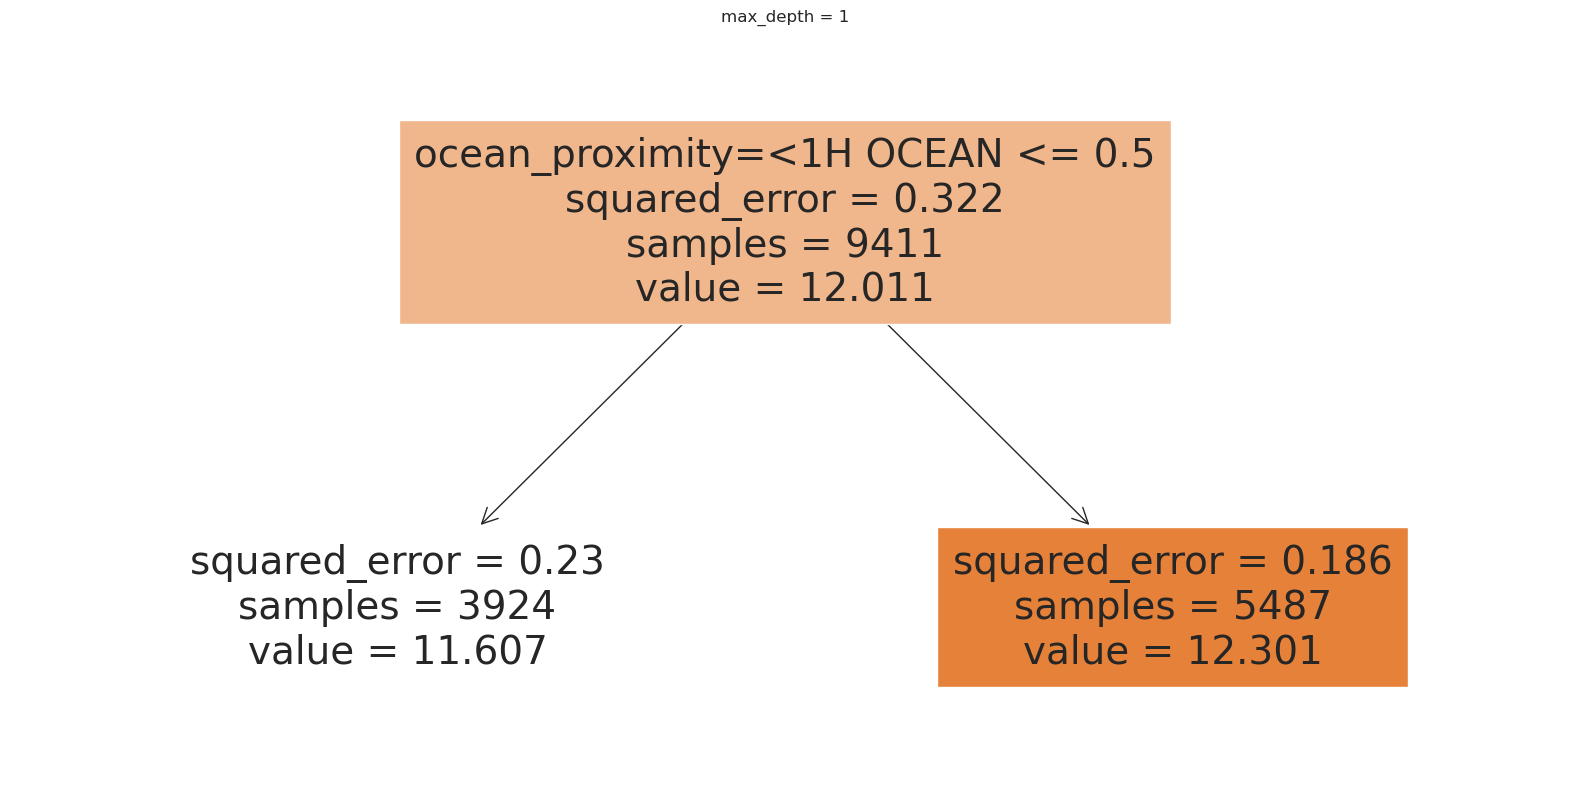

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [50]:
plt.figure(figsize=(20, 10))
_ = tree.plot_tree(dtr, filled=True, feature_names=feature_names)
plt.title(f"max_depth = {max_depth}")
plt.show()
print(export_text(dtr, feature_names=feature_names))

**Answer**: `ocean_proximity`

## Question 2


Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [53]:
# parameter
n_estimators = 10
random_state = 1
n_jobs = -1

In [54]:
rfr = RandomForestRegressor(n_estimators=n_estimators,
                            random_state=random_state,
                            n_jobs=n_jobs)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [56]:
y_pred = rfr.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.3f}")

RMSE: 0.245


**Answer:** $0.245$

## Question 3


Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50
- 160

In [63]:
scores = []
rs = 1
n_estimators_values = range(10, 201, 10)

for n in tqdm(n_estimators_values, total=len(n_estimators_values)):
    rfr = RandomForestRegressor(n_estimators=n,
                                random_state=rs)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, rmse))

df_scores = pd.DataFrame(scores, columns=["n_estimators", "rmse"])
df_scores

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [27:42<00:00, 83.15s/it] 


,n_estimators,rmse
0,10,0.245012
1,20,0.239098
2,30,0.236946
3,40,0.235247
4,50,0.235289
5,60,0.234992
6,70,0.234870
7,80,0.234975
8,90,0.234867
9,100,0.234579


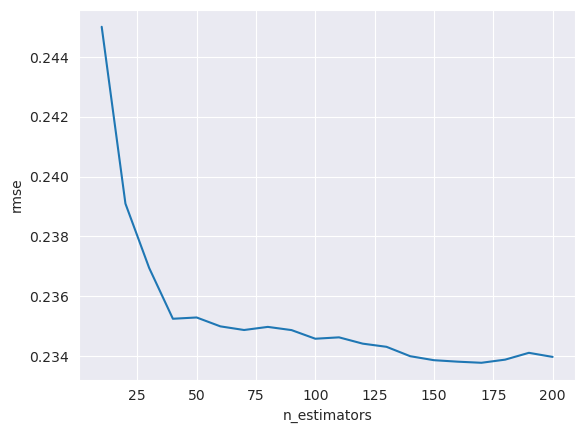

In [65]:
plt.plot(df_scores["n_estimators"], df_scores["rmse"])
plt.xlabel("n_estimators"); plt.ylabel("rmse")
plt.show()

**Answer:** `160`

## Question 4


Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25


In [ ]:
scores = []
rs = 1

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rfr = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=rs)
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((d, n, rmse))

In [ ]:
columns = ["max_depth", "n_estimators", "rmse"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

In [ ]:
# Sort the dataframe by rmse and display the best ones
df_scores.sort_values(by="rmse", ascending=False).head()